This script setup the experiments, assuming that the l4s part has been installed correctly. 

In [2]:
import subprocess

tx0_prefix = "ssh -p 25010 PeterYao@pc603.emulab.net"
router0_prefix = "ssh -p 25010 PeterYao@pc606.emulab.net"
router1_prefix = "ssh -p 25010 PeterYao@pc604.emulab.net"
rx0_prefix = "ssh PeterYao@pc615.emulab.net"

nodes_prefix = [tx0_prefix, router0_prefix, router1_prefix, rx0_prefix]

class node:
    def __init__(self, node_ssh_prefix) -> None:
        self.ssh_prefix = node_ssh_prefix

    def execute(self, command, background=False):
        if background:
            print("executing in background")
            # full_command = f"{self.ssh_prefix} 'setsid nohup {command} > /dev/null 2>&1 &'"
            full_command = f'{self.ssh_prefix} "{command}"'
            subprocess.Popen(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        else:
            full_command = f'{self.ssh_prefix} "{command}"'
            result = subprocess.run(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if result.returncode == 0:
                print(result.stdout.decode('utf-8'))
            else:
                print(f"Error: {result.stderr.decode('utf-8')}")
        return None
        
tx0_node = node(tx0_prefix)
delay_node = node(router0_prefix)
router_node = node(router1_prefix)
rx0_node = node(rx0_prefix)

nodes = [tx0_node, delay_node, router_node, rx0_node]





# Experiment 1 50-50 base thp and latency

In [3]:
commands_noecn = "bash -c 'sudo sysctl -w net.ipv4.tcp_congestion_control=cubic; sudo sysctl -w net.ipv4.tcp_ecn=0'"
for node in nodes:
    node.execute(commands_noecn)
    
print("validating...")
for node in nodes:
    node.execute("sudo sysctl net.ipv4.tcp_congestion_control")
    node.execute("sudo sysctl net.ipv4.tcp_ecn")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

validating...
net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0



In [4]:
# modify the delay on the delay node
base_rtt = 25
delay_interfaces = ["eth1", "eth2"]

for e in delay_interfaces:
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=base_rtt/2)
    delay_node.execute(cmds)

In [5]:
delay_node.execute("sudo tc qdisc show dev eth1")
delay_node.execute("sudo tc qdisc show dev eth2")

qdisc netem 8001: root refcnt 2 limit 60000 delay 12.5ms

qdisc netem 8002: root refcnt 2 limit 60000 delay 12.5ms



In [66]:
# set up the btl node
n_bdp = 2
base_rtt = 25
btl_capacity = 100 #in Mbps

# fixed values
btl_limit    = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 
packet_number=int(btl_limit/1500)+1

print("btl limit: ", btl_limit)
print("packet number: ", packet_number)

btl limit:  625000
packet number:  417


In [1]:
from fabric import Connection

router = Connection(
    host='pc604.emulab.net',
    user='PeterYao',
    port=25010,
)


delay = Connection(
    host='pc606.emulab.net',
    user = 'PeterYao',
    port=25010,
)

tx = Connection(
    host='pc603.emulab.net',
    user = 'PeterYao',
    port=25010,
)

rx = Connection(
    host='pc615.emulab.net',
    user
    = 'PeterYao',  
    port=22,
)

result = router.run('df -h')

Filesystem      Size  Used Avail Use% Mounted on
tmpfs            96M  700K   96M   1% /run
/dev/xvda3       63G  3.8G   56G   7% /
tmpfs           480M     0  480M   0% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/xvda1      256M  8.6M  248M   4% /boot/efi
tmpfs            96M     0   96M   0% /run/user/39791


In [6]:
# setup the router queueing discipline
router_egress_name = "eth2"

cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)
            
cmds_specific = "sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer}".format(iface=router_egress_name, buffer=btl_limit)

router.run(cmds_prefix)    
router.run(cmds_specific)
router.run("sudo tc qdisc show dev eth2")  

router.run("sudo tc qdisc show dev eth2")



qdisc htb 1: root refcnt 2 r2q 10 default 0x3 direct_packets_stat 0 direct_qlen 1000
qdisc bfifo 3: parent 1:3 limit 625000b


<Result cmd='sudo tc qdisc show dev eth2' exited=0>

In [46]:
rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_congestion_control=cubic")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_congestion_control=cubic")

rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0
net.ipv4.tcp_ecn = 0


<Result cmd="sudo -S -p '[sudo] password: ' ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0" exited=0>

In [82]:
router.run("chmod +x monitor.sh")
router.run("./monitor.sh eth2 60 1 > monitor.log &", asynchronous =True)


AttributeError: 'Promise' object has no attribute 'exited'

In [76]:
# run the iperf command
rx.run("killall iperf3", warn=True)

rx.sudo("ip netns exec ue1 iperf3 -s -1 -p 4000 -D")
rx.sudo("ip netns exec ue3 iperf3 -s -1 -p 4000 -D")

local_file_path = r"d:\5g notes\5G-E2E-Wireless-Notes-OAI\exp-9-15\exp.sh"

# the monitor queue length shell script has already been copied to the router1 node
router.run("nohup ./monitor.sh eth2 60 1 > monitor.log 2>&1 &", pty=False)

# the put command is funny on windows, so I copy paster the exp file manually to the tx node
tx.run("ls -l")
tx.run("chmod +x ~/exp.sh")
tx.run("~/exp.sh cubic-ecn-none")



iperf3: no process found
Socket exception: 远程主机强迫关闭了一个现有的连接。 (10054)


ConnectionResetError: [WinError 10054] 远程主机强迫关闭了一个现有的连接。

In [48]:
tx.run("ls -l")
tx.get("cubic_ecn_none-result-ue1.json")
tx.get("cubic_ecn_none-result-ue2.json")
tx.get("cubic_ecn_none-ss-ue1.txt")
tx.get("cubic_ecn_none-ss-ue2.txt")

total 86032
-rw-r--r-- 1 PeterYao nyunetworks    34585 Sep 15 00:50 cubic_ecn_none-result-ue1.json
-rw-r--r-- 1 PeterYao nyunetworks    34634 Sep 15 00:50 cubic_ecn_none-result-ue2.json
-rw-r--r-- 1 PeterYao nyunetworks   222167 Sep 15 00:50 cubic_ecn_none-ss-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks   236460 Sep 15 00:50 cubic_ecn_none-ss-ue2.txt
drwxr-xr-x 2 PeterYao nyunetworks     4096 May 23 12:09 debian_build
-rwxr-xr-x 1 PeterYao nyunetworks     2021 Sep 15 00:15 exp.sh
-rw-r--r-- 1 PeterYao nyunetworks 87449891 May 23 12:09 l4s-testing.zip
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 14 23:17 test.txt


Dataset 1 - Overall Throughput: 0.53 Mbps
Dataset 1 - Average Retransmissions: 3.38

Dataset 2 - Overall Throughput: 0.56 Mbps
Dataset 2 - Average Retransmissions: 3.42


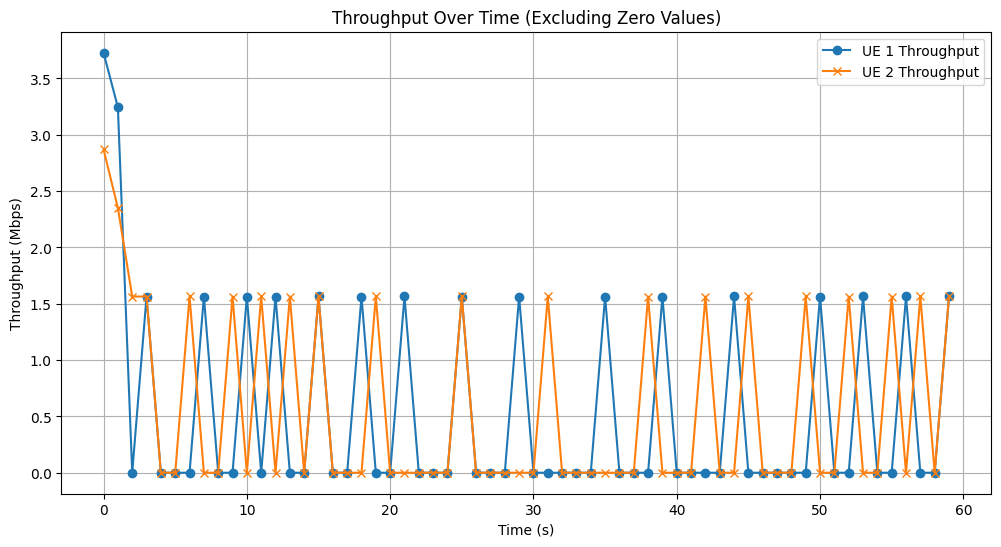

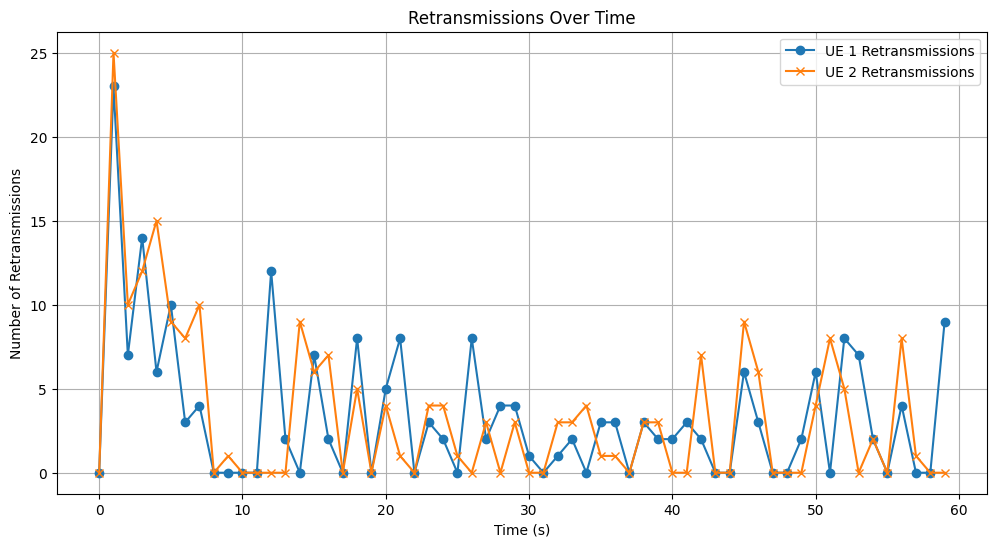

In [50]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with the paths to your actual iperf JSON result files
file1 = 'cubic_ecn_none-result-ue1.json'
file2 = 'cubic_ecn_none-result-ue2.json'

def load_iperf_data(filename):
    """Load iperf JSON data from a file and return a pandas DataFrame."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Initialize lists to store the extracted data
    intervals = data['intervals']
    start_times = []
    end_times = []
    durations = []
    throughputs = []
    retransmissions = []
    
    # Iterate over each interval in the data
    for interval in intervals:
        sum_data = interval['sum']
        start_times.append(sum_data['start'])
        end_times.append(sum_data['end'])
        durations.append(sum_data['seconds'])
        # Convert throughput from bits per second to megabits per second
        throughput_mbps = sum_data['bits_per_second'] / 1_000_000  # Divide by 1,000,000
        throughputs.append(throughput_mbps)
        retransmissions.append(sum_data.get('retransmits', 0))  # Retransmits might not be present in UDP tests
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Duration': durations,
        'Throughput (Mbps)': throughputs,
        'Retransmissions': retransmissions
    })
    
    return df

def filter_zero_throughput(df):
    """Filter out data points where throughput is zero."""
    return df[df['Throughput (Mbps)'] != 0].reset_index(drop=True)

# Load data from both files
df1 = load_iperf_data(file1)
df2 = load_iperf_data(file2)

# Filter out zero throughput data points for plotting throughput
# df1_nonzero = filter_zero_throughput(df1)
# df2_nonzero = filter_zero_throughput(df2)

# Calculate overall throughput and average retransmissions for each dataset
overall_throughput1 = df1['Throughput (Mbps)'].mean()
average_retransmits1 = df1['Retransmissions'].mean()

overall_throughput2 = df2['Throughput (Mbps)'].mean()
average_retransmits2 = df2['Retransmissions'].mean()

print(f"Dataset 1 - Overall Throughput: {overall_throughput1:.2f} Mbps")
print(f"Dataset 1 - Average Retransmissions: {average_retransmits1:.2f}")

print(f"\nDataset 2 - Overall Throughput: {overall_throughput2:.2f} Mbps")
print(f"Dataset 2 - Average Retransmissions: {average_retransmits2:.2f}")

# Plotting the throughputs over time (excluding zero throughput data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Throughput (Mbps)'], label='UE 1 Throughput', marker='o')
plt.plot(df2['Start Time'], df2['Throughput (Mbps)'], label='UE 2 Throughput', marker='x')
plt.title('Throughput Over Time (Excluding Zero Values)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the retransmissions over time (include all data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Retransmissions'], label='UE 1 Retransmissions', marker='o')
plt.plot(df2['Start Time'], df2['Retransmissions'], label='UE 2 Retransmissions', marker='x')
plt.title('Retransmissions Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Retransmissions')
plt.legend()
plt.grid(True)
plt.show()


COMMENT: the cwnd calculation is not showing the expected result. 

In [56]:

name_tx0="cubic_ecn_none"


# the csv files generated is of the following format
# timestamp, fd, cwnd, srtt

file_out_tx0_csv = name_tx0+"-ss.csv"

for ue_id in range(1, 3):
    print("Running to generate csv files " + name_tx0)

    ss_tx0_script_processing="""

    f_1={types}; 
    ue_id={ue_id};
    rm -f ${{f_1}}-ss-${{ue_id}}.csv;
    cat ${{f_1}}-ss-${{ue_id}}.txt | sed -e ":a; /<->$/ {{ N; s/<->\\n//; ba; }}"  | grep "iperf3" | grep -v "SYN-SENT"> ${{f_1}}-ss-processed-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | awk '{{print $1}}' > ts-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bcwnd:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' ' > cwnd-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\brtt:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' '  | cut -d '/' -f 1   > srtt-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bfd=.*?(\s|$)' | awk -F '[=,]' '{{print $2}}' | tr -d ')' | tr -d ' '   > fd-${{f_1}}-${{ue_id}}.txt;
    paste ts-${{f_1}}-${{ue_id}}.txt fd-${{f_1}}-${{ue_id}}.txt cwnd-${{f_1}}-${{ue_id}}.txt srtt-${{f_1}}-${{ue_id}}.txt -d ',' > ${{f_1}}-ss-${{ue_id}}.csv;""".format(types=name_tx0, ue_id="ue"+str(ue_id))

    tx.run(ss_tx0_script_processing)

tx.get("cubic_ecn_none"+"-ss-ue1.csv")
tx.get("cubic_ecn_none"+"-ss-ue2.csv")


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_34072\588717655.py:9: SyntaxWarning: invalid escape sequence '\s'
  ss_tx0_script_processing="""


Running to generate csv files cubic_ecn_none
Running to generate csv files cubic_ecn_none


In [62]:
import itertools
import json
import pandas as pd

throughput_data = {}  # Initialize the dictionary
srtt_data = {}
cwnd_data= pd.DataFrame()
srtt_data_time= pd.DataFrame()

for ue_id in range(1, 3):
    name_tx0="cubic_ecn_none"
    ue_str = "ue"+str(ue_id)

    # Load the JSON output file into a Python object
    with open(f"{name_tx0}-result-{ue_str}.json") as f:
        iperf3_data = json.load(f)

    throughput_data[name_tx0+ue_str] = iperf3_data['end']['sum_received']['bits_per_second'] / (1000000 * 1)  # to convert Mbit

    # Average SRTT for Each Flow
    columns = ['timestamp', 'flow ID', 'cwnd', 'srtt']
    df_f1 = pd.read_csv(f"{name_tx0}-ss-{ue_str}.csv", names=columns)
    
    # Filter out rows with flow ID = 4, they are for the control flows
    df_f1 = df_f1[df_f1['flow ID'] != 4].reset_index(drop=True)

    average_RTT_f1 = df_f1['srtt'].mean()
    
    cwnd_data[name_tx0+ue_str] = df_f1['cwnd']
    srtt_data[name_tx0+ue_str] = average_RTT_f1
    srtt_data_time[name_tx0+ue_str] = df_f1['srtt']

# Save throughput_data to a JSON file
with open('throughput_data.json', 'w') as f:
    json.dump(throughput_data, f)

# Save srtt_data to a JSON file
with open('srtt_data.json', 'w') as f:
    json.dump(srtt_data, f)

cwnd_data.to_csv("consolidated_cwnd_data.csv", index=False)
srtt_data_time.to_csv("time_srtt.csv", index=False)

btl limit no ecn:  625000


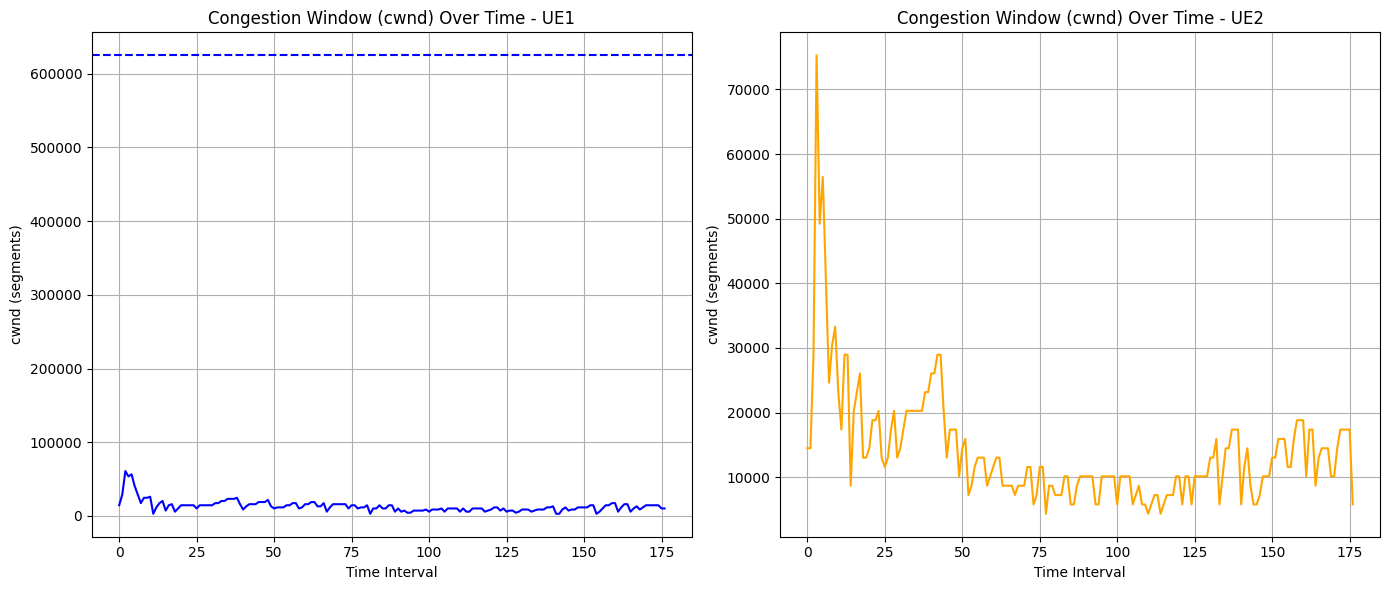

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

btl_limit_noecn=int(1000*btl_capacity*base_rtt*n_bdp /8)

print("btl limit no ecn: ", btl_limit_noecn)

# Specify the filename
filename = 'consolidated_cwnd_data.csv'  # Replace with your actual filename

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)

# Extract data for each UE
ue1_data = df['cubic_ecn_noneue1']
ue2_data = df['cubic_ecn_noneue2']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for UE1
axes[0].plot(ue1_data*1448, marker='', color='blue')
axes[0].set_title('Congestion Window (cwnd) Over Time - UE1')
axes[0].set_xlabel('Time Interval')
axes[0].set_ylabel('cwnd (segments)')
axes[0].axhline(y=btl_limit_noecn, color='b', linestyle='--', label=f'Buffer Size')
axes[0].grid(True)

# Plot for UE2
axes[1].plot(ue2_data*1448, marker='', color='orange')
axes[1].set_title('Congestion Window (cwnd) Over Time - UE2')
axes[1].set_xlabel('Time Interval')
axes[1].set_ylabel('cwnd (segments)')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
